In [175]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from cv2 import aruco
import msgpack as mp
import msgpack_numpy as mpn
from tqdm import tqdm
from pd_support import *
from scipy.spatial.transform import Rotation as R
import polars as pl
import os
from scipy.interpolate import interp1d

## Define calibration path

In [176]:
_pth = os.path.dirname(os.getcwd())
_parent_folder = "data"
_calib_folder_name = "calib_1200_480_mf_04"

_webcam_calib_folder = os.path.join(
    _pth, _parent_folder, "calibration", _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "webcam_color.msgpack")
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join(_webcam_calib_folder, "webcam_calibration.msgpack")

## path definition

In [177]:
_recording_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
_data_dir = "high_res_waf"
_data_path = os.path.join(
    _recording_dir, "recordings", _data_dir, "webcam_color.msgpack"
)

ar_parameters = aruco.DetectorParameters()
ar_dict = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_MIP_36H12)
ar_detector = aruco.ArucoDetector(ar_dict, ar_parameters)
markerLength = 0.05
markerSeperation = 0.01

default_ids = [12, 88, 89]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ar_dict,
)

In [178]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [179]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_ARUCO_ORIGINAL)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)
_video_length = 0

for _frame in _video_data:
    _video_length += 1

_video_file.close()

In [180]:
calibration_flags = cv2.CALIB_CB_CLUSTERING
term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

In [181]:
corners, ids = [], []
with open(_data_path, "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    img_size = next(unpacker)
    for _frame in tqdm(unpacker):
        _c, _i = _frame
        corners.append(_c)
        ids.append(_i)

timestamp = []
sync = []

with open(
    os.path.join(os.path.dirname(_data_path), "webcam_timestamp.msgpack"), "rb"
) as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])
sync = np.array(sync).astype(bool)

1851it [00:00, 147839.75it/s]


In [182]:
ar_df = {"time": timestamp, "sync": sync}
ar_df = pl.from_dict(ar_df)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [183]:
mocap_df, st_time = read_rigid_body_csv(
    os.path.join(os.path.dirname(_data_path), f"{_data_dir}.csv")
)
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

d:\CMC\pyprojects\programs_rpi\programs\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [184]:
tr = get_rb_marker_name(1)
tl = get_rb_marker_name(4)
br = get_rb_marker_name(2)
bl = get_rb_marker_name(5)

In [185]:
pulse_sweep = False
for idx, val in enumerate(ar_df["sync"]):
    if val == True and not pulse_sweep:
        start_pulse = idx
        pulse_sweep = True
    if val == False and pulse_sweep:
        end_pulse = idx
        break
ar_df = ar_df[start_pulse:end_pulse]
corners = corners[start_pulse:end_pulse]
ids = ids[start_pulse:end_pulse]

_time_diff = ar_df["time"][0] - mocap_df["time"][0]

ar_df = ar_df.with_columns([(pl.col("time") - _time_diff).alias("time")])

In [186]:
mocap_mean = {"x": [], "y": [], "z": []}
mocap_mean["x"] = mocap_df[[tr["x"], tl["x"], br["x"], bl["x"]]].to_numpy().mean(axis=1)
mocap_mean["y"] = mocap_df[[tr["y"], tl["y"], br["y"], bl["y"]]].to_numpy().mean(axis=1)
mocap_mean["z"] = mocap_df[[tr["z"], tl["z"], br["z"], bl["z"]]].to_numpy().mean(axis=1)

mocap_qt = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()

mocap_rotation = R.from_quat(mocap_qt).as_matrix()

mocap_mean = pl.from_dict(mocap_mean)

mt_dict = {"x": [], "y": [], "z": []}
rmat_m = mocap_rotation[0]

for i in range(len(mocap_df["time"])):
    tvec_ar = rmat_m.T @ (
        mocap_mean[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - mocap_mean[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    )
    tvec_ar = tvec_ar.T[0]
    mt_dict["x"].append(tvec_ar[0])
    mt_dict["y"].append(tvec_ar[1])
    mt_dict["z"].append(tvec_ar[2])
mt_dict["time"] = mocap_df["time"]

## Interoplating

In [187]:
mocap = pl.from_dict(mt_dict)

x1 = interp1d(mocap["time"].dt.epoch(), mocap["x"], fill_value="extrapolate")
y1 = interp1d(mocap["time"].dt.epoch(), mocap["y"], fill_value="extrapolate")
z1 = interp1d(mocap["time"].dt.epoch(), mocap["z"], fill_value="extrapolate")

mocap_ip = {"time": ar_df["time"]}
mocap_ip["x"] = x1(ar_df["time"].dt.epoch())
mocap_ip["y"] = y1(ar_df["time"].dt.epoch())
mocap_ip["z"] = z1(ar_df["time"].dt.epoch())
mocap_ip = pl.from_dict(mocap_ip)

## estimation

In [188]:
_video_pth = _webcam_calib_video
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

marker_corners = []
marker_ids = []
counter = 0
rnd = np.random.choice(_video_length, 20, replace=False)
img_size = next(_video_data)
for idx, data_points in enumerate(_video_data):
    break

In [197]:
error_dict = {
    "error": [],
    "mtx": [],
    "dist_coeffs": [],
    "error_x": [],
    "error_z": [],
    "error_y": [],
    "mean_err": [],
    "max_x": [],
    "max_y": [],
    "max_z": [],
}


for i in tqdm(range(300)):
    try:
        _video_pth = _webcam_calib_video
        _video_file = open(_video_pth, "rb")
        _video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

        marker_corners = []
        marker_ids = []
        counter = 0
        rnd = np.random.choice(_video_length, 20, replace=False)
        img_size = next(_video_data)

        for idx, data_points in enumerate(_video_data):
            if idx in rnd:
                calib_corners, calib_ids = data_points

                marker_corners.append(calib_corners)
                marker_ids.append(calib_ids)
                counter += 1

        _video_file.close()

        processed_image_points = []
        processed_object_points = []
        for _f in range(len(marker_corners)):
            current_object_points, current_image_points = board.matchImagePoints(
                marker_corners[_f], marker_ids[_f]
            )
            try:
                if current_object_points.any() and current_image_points.any():
                    processed_image_points.append(current_image_points)
                    processed_object_points.append(current_object_points)
            except:
                pass

        mtx2 = np.eye(3)
        dist2 = np.zeros((1, 8))

        # a, mtx1, dist1, b, c=cv2.calibrateCamera(processed_object_points, processed_image_points, (1200,480), mtx2, dist2, flags=calibration_flags, criteria=term_criteria)
        a, mtx1, dist1, b, c = cv2.calibrateCamera(
            processed_object_points, processed_image_points, (1200, 480), mtx2, dist2
        )

        camera_matrix = mtx1
        dist_coeffs = dist1

        rvecs = []
        tvecs = []
        for _c, _i in zip(corners, ids):
            if (_i is not None and len(_i) > 0) and all(
                item in default_ids for item in np.array(_i)
            ):
                rotation_vectors, translation_vectors = estimate_pose_single_markers(
                    corners=_c,
                    marker_size=0.05,
                    camera_matrix=camera_matrix,
                    distortion_coefficients=dist_coeffs,
                )
                rvecs.append(rotation_vectors[0][0])
                tvecs.append(translation_vectors[0][0])

            else:
                rvecs.append(np.array([np.nan, np.nan, np.nan]))
                tvecs.append(np.array([np.nan, np.nan, np.nan]))
        tvecs = np.array(tvecs)
        rvecs = np.array(rvecs)

        t_dict = {"x": [], "y": [], "z": []}
        rmat = cv2.Rodrigues(rvecs[1])[0]

        for i in range(len(tvecs)):
            tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
            tvec = tvec.T[0]
            t_dict["x"].append(tvec[0])
            t_dict["y"].append(tvec[1])
            t_dict["z"].append(tvec[2])

        _ex = np.nanmean(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
        _ey = np.nanmean(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
        _ez = np.nanmean(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())

        error_dict["error_x"].append(_ex)
        error_dict["error_y"].append(_ey)
        error_dict["error_z"].append(_ez)
        error_dict["mean_err"].append(np.nanmean([_ex, _ey, _ez]))
        error_dict["max_x"].append(
            np.nanmax(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
        )
        error_dict["max_y"].append(
            np.nanmax(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
        )
        error_dict["max_z"].append(
            np.nanmax(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())
        )
        error_dict["mtx"].append(mtx1)
        error_dict["dist_coeffs"].append(dist_coeffs)
        error_dict["error"].append(a)
    except:
        pass
    # break

100%|██████████| 300/300 [07:17<00:00,  1.46s/it]


## Check minimum graph

In [275]:
key = "mean_err"

index = np.argmin(error_dict[key])

index = 65
camera_matrix = error_dict["mtx"][index]
dist_coeffs = error_dict["dist_coeffs"][index]

rvecs = []
tvecs = []
for _c, _i in zip(corners, ids):
    if (_i is not None and len(_i) > 0) and all(
        item in default_ids for item in np.array(_i)
    ):
        rotation_vectors, translation_vectors = estimate_pose_single_markers(
            corners=_c,
            marker_size=0.05,
            camera_matrix=camera_matrix,
            distortion_coefficients=dist_coeffs,
        )
        rvecs.append(rotation_vectors[0][0])
        tvecs.append(translation_vectors[0][0])

    else:
        rvecs.append(np.array([np.nan, np.nan, np.nan]))
        tvecs.append(np.array([np.nan, np.nan, np.nan]))

tvecs = np.array(tvecs)
rvecs = np.array(rvecs)

t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(rvecs[1])[0]

for i in range(len(tvecs)):
    tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])

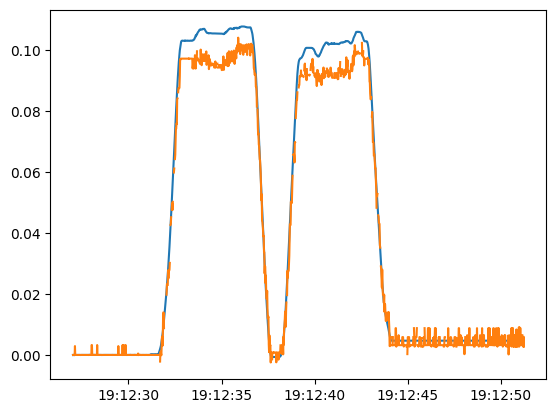

In [276]:
plt.plot(ar_df["time"], mocap_ip["z"])
plt.plot(ar_df["time"], t_dict["z"])

In [277]:
_cumulative_error = (
    np.array(error_dict["max_x"])
    + np.array(error_dict["max_y"])
    + np.array(error_dict["max_z"])
)
np.argmin(_cumulative_error)

65

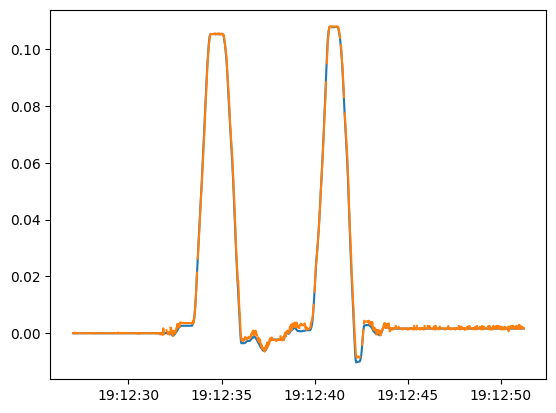

In [278]:
plt.plot(ar_df["time"], mocap_ip["x"])
plt.plot(ar_df["time"], t_dict["x"])

In [279]:
mtx1 = error_dict["mtx"][index]
dist1 = error_dict["dist_coeffs"][index]

In [280]:
error_dict["dist_coeffs"][index]

array([[-0.1243466 ,  0.17095445, -0.00501361, -0.01656926, -0.10179671]])

In [281]:
import toml

data = toml.load(r"D:\CMC\pyprojects\programs_rpi\programs\calib_test.toml")
data["calibration"]["camera_matrix"] = mtx1.tolist()
data["calibration"]["dist_coeffs"] = dist1.tolist()
data["camera"]["resolution"] = (1200, 400)
with open(r"D:\CMC\pyprojects\programs_rpi\programs\calib_test.toml", "w") as f:
    toml.dump(data, f)

In [282]:
error_dict["max_z"][index]

0.01196630040604861